In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

from subprocess import call
from networkit import *

In [2]:
data = {}

for path in glob.glob(os.path.expanduser("/amd.home/home/i11/zeitz/ma/data/results/paper/lfr_params/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
algo_name_mapping = {
    'synchronous local moving with map equation': 'Distr. MapEq',
    'synchronous local moving with modularity': 'Distr. Modularity',
    'sequential louvain': 'Seq. Louvain'
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: ' w. Seq.', np.NaN: '' })

In [11]:
frames['program_run']['mu'] = pd.to_numeric(frames['program_run']['graph'].str[-7:-6])

In [4]:
def siml(x):
    ground_truth = community.readCommunities("/amd.home/home/i11/zeitz/ma/" + x['graph'][:-5] + 'part')
    
    if 'seq_louvain' in x['binary']:
        clustering = community.readCommunities('/amd.home/home/i11/zeitz/ma/' + x['path'])
    else:
        files = sorted(glob.glob(os.path.expanduser('/amd.home/home/i11/zeitz/ma/' + x['path'].replace('@@@@-#####', '*'))))
        call("rm tmp", shell=True)
        call("cat {} > tmp".format(' '.join(files)), shell=True)
        clustering = community.BinaryEdgeListPartitionReader(0, 4).read('tmp')
        call("rm tmp", shell=True)

    g = graph.Graph(ground_truth.numberOfElements())
    nmi = 1.0 - community.NMIDistance().getDissimilarity(g, clustering, ground_truth)
    ari = 1.0 - community.AdjustedRandMeasure().getDissimilarity(g, clustering, ground_truth)
    return pd.Series([nmi, ari, clustering.numberOfSubsets()])
    
frames['clustering'][['NMI', 'ARI', 'cluster_count']] = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .apply(siml, axis=1)

read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.2.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.2.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.4.part
read communities from: /amd.home/home/i11/zeitz/ma/data/results/paper/lfr_params/seq_louvain/graph_g2_b1_m0.4.run0.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.3.part
read communities from: /amd.home/home/i11/zeitz/ma/data/results/paper/lfr_params/seq_louvain/graph_g2_b1_m0.3.run0.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.1.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.8.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.2.part
read communities from: /amd.home/home/i11/zeit

read communities from: /amd.home/home/i11/zeitz/ma/data/results/paper/lfr_params/seq_louvain/graph_g2_b1_m0.9.run1.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.9.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.7.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.1.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.2.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.4.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.4.part
read communities from: /amd.home/home/i11/zeitz/ma/data/results/paper/lfr_params/seq_louvain/graph_g2_b1_m0.4.run1.part
read communities from: /amd.home/home/i11/zeitz/ma/data/graphs/lfr_params_paper/graph_g2_b1_m0.9.part
read communities from: /amd.home/home/i11/zeit

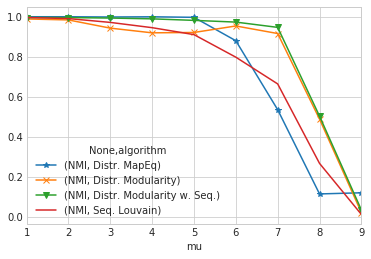

In [15]:
frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['mu', 'algorithm'])['NMI'].max().to_frame().unstack().plot(style=['-*', '-x', '-v'])

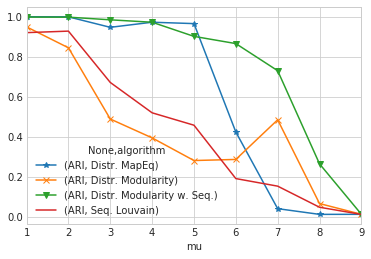

In [20]:
frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['mu', 'algorithm'])['ARI'].min().to_frame().unstack().plot(style=['-*', '-x', '-v'])

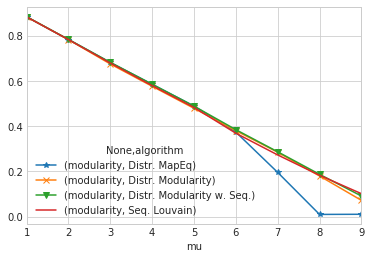

In [16]:
frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['mu', 'algorithm'])['modularity'].mean().to_frame().unstack().plot(style=['-*', '-x', '-v'])

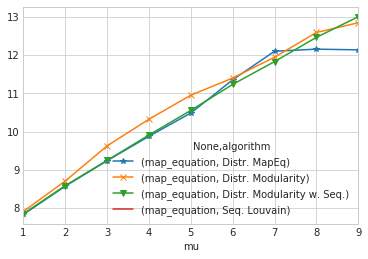

In [17]:
frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['mu', 'algorithm'])['map_equation'].mean().to_frame().unstack().plot(style=['-*', '-x', '-v'])